# Visualizing a trained model

Given a trained model, we would also like to visualize the model and study the patterns it has learned. To do this, we will first query the model to determine vectors correpsonding to each abstract that it has learned, and then 


.. note::
   We'll be using [umap](https://umap-learn.readthedocs.io/en/latest/) for this tutorial, so if you don't have it installed, please do so before running this notebook. 

In [1]:
import chaotic_neural as cn

import numpy as np
import matplotlib.pyplot as plt

import umap
from sklearn.preprocessing import StandardScaler

### Loading the trained model:

In [2]:
model_data = cn.load_trained_doc2vec_model('astro-ph-GA-23May2021', cn_dir = '../../chaotic_neural/')
model, all_titles, all_abstracts, all_authors, train_corpus, test_corpus = model_data

### Generating vectors corresponding to each document in the corpus:

In [3]:
example_dv = model.dv[0]

all_vectors = np.zeros((len(example_dv), len(train_corpus)))
for i in range(len(train_corpus)):
    all_vectors[0:,i] = model.dv[i]

### Using UMAP, we can now generate an embedding of the 50-dim vector space in two dimensions:

In [4]:
reducer = umap.UMAP()

scaled_vectors = StandardScaler().fit_transform(all_vectors.T, )
embedding = reducer.fit_transform(scaled_vectors)
embedding.shape

(26172, 2)

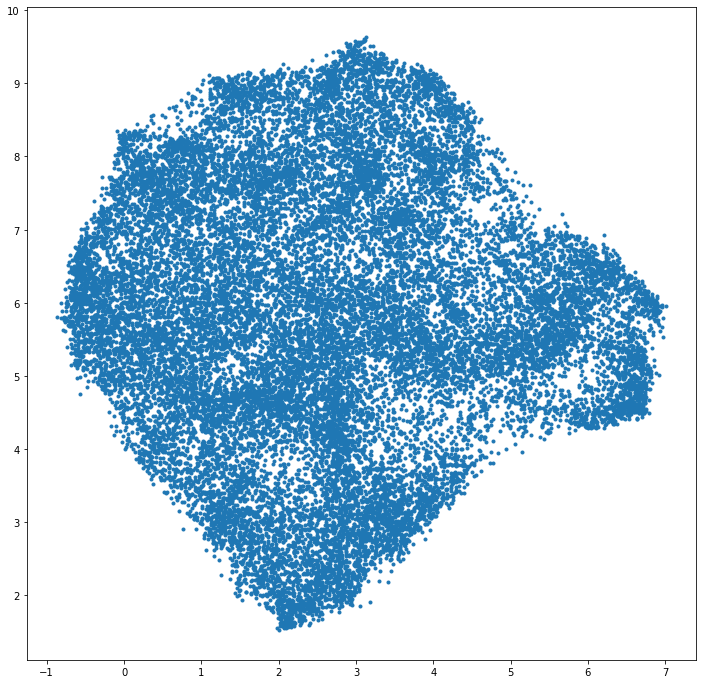

In [5]:
plt.figure(figsize=(12,12))
plt.plot(embedding[0:,0],embedding[0:,1],'.')
plt.show()

Before we can proceed further, let us first check if we can reliably transform vectors into this compressed UMAP space using an example vector.

In [6]:

vector1 = all_vectors[0:,100]
print(vector1.shape)

embedding_vector = reducer.transform(vector1.reshape(1,len(example_dv)))
print(embedding_vector)
print(embedding[100,0:])

(50,)
[[1.272584 6.64198 ]]
[1.2619421 6.675914 ]


### Let's create a more dynamic version of the plot.

Now that it works, let's figure out where different areas are located in our set of papers.

.. note::
   We'll be using [bokeh](https://docs.bokeh.org/en/latest/index.html) for this plot, so if you don't have it installed, please do so before running this notebook. 

In [7]:
from bokeh.plotting import ColumnDataSource, figure, output_notebook, show

output_notebook()

source = ColumnDataSource(data=dict(
    x=embedding[0:,0],
    y=embedding[0:,1],
    title=all_titles,
))

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("title", "@title"),
]

p = figure(plot_width=700, plot_height=700, tooltips=TOOLTIPS,
           title="UMAP projection of trained ArXiv corpus")

p.circle('x', 'y', size=3, source=source, alpha=0.3)

show(p)



Loading BokehJS ...

### Check different areas of the plot by quantities like publishing year, number of authors, and primary category. We expect no large correlations for any of these quantities, and this serves more as a sanity check. 

In [8]:
with open("gal_feeds.pkl", "rb") as fp:
    gal_feeds = cn.pickle.load(fp)

In [9]:
all_years = []
num_authors = []
all_primary_cat = []
for i in cn.tqdm(range(len(gal_feeds))):
    for j in range(len(gal_feeds[i].entries)):
        all_years.append(int(gal_feeds[i].entries[j].published[0:4]))
        num_authors.append(len(gal_feeds[i].entries[j].authors))
        all_primary_cat.append(gal_feeds[i].entries[j].arxiv_primary_category['term'])

100%|██████████| 1000/1000 [00:00<00:00, 7349.47it/s]


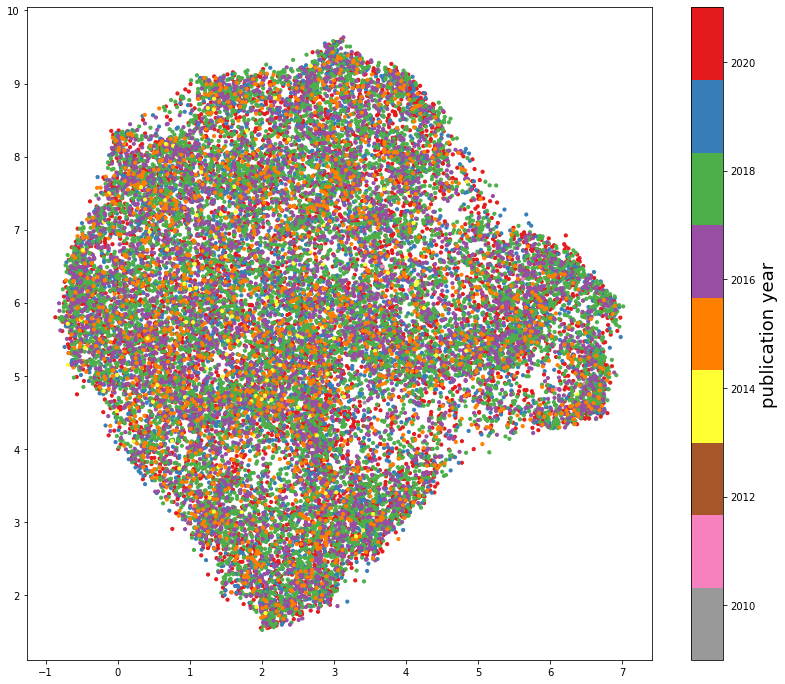

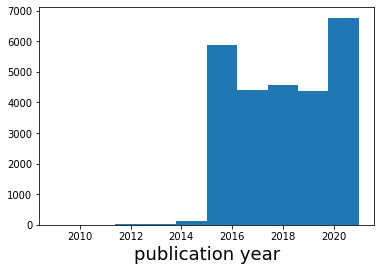

In [10]:
%matplotlib inline

plt.figure(figsize=(14,12))
plt.scatter(embedding[0:,0],embedding[0:,1],c=np.array(all_years),s=10,cmap='Set1_r')
clbr = plt.colorbar()
clbr.set_label('publication year',fontsize=18)
plt.show()

plt.hist(np.array(all_years))
plt.xlabel('publication year',fontsize=18)
plt.show()

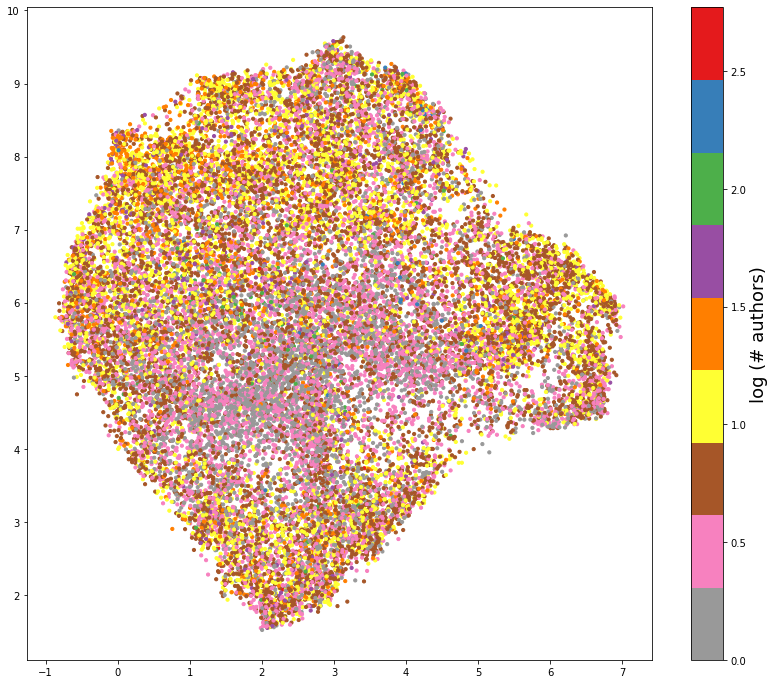

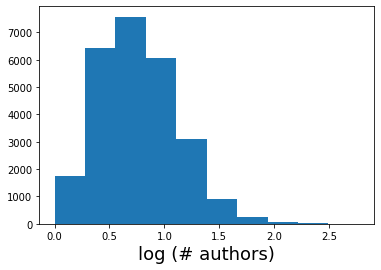

In [11]:
%matplotlib inline

plt.figure(figsize=(14,12))
plt.scatter(embedding[0:,0],embedding[0:,1],c=np.log10(np.array(num_authors)),s=10,cmap='Set1_r')
clbr = plt.colorbar()
clbr.set_label('log (# authors)',fontsize=18)
plt.show()

plt.hist(np.log10(np.array(num_authors)))
plt.xlabel('log (# authors)',fontsize=18)
plt.show()

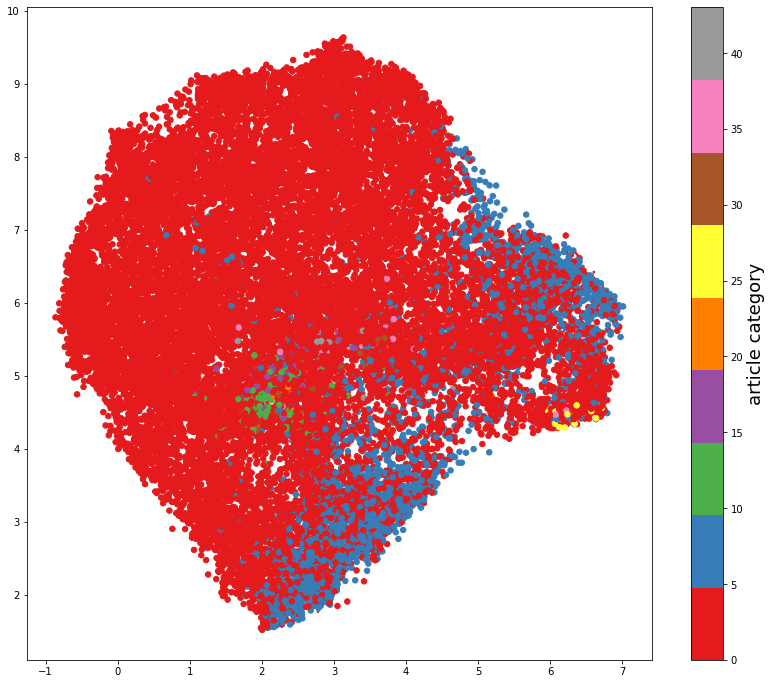

In [12]:
%matplotlib inline

unique_categories = np.unique(all_primary_cat)
pcarray = np.array(all_primary_cat)

allcats = np.zeros((len(all_primary_cat),))
for i in range(len(unique_categories)):
    allcats[pcarray == unique_categories[i]] = i

sizecats = np.ones_like(allcats)
sizecats[allcats == 1] = 3
sizecats[allcats != 1] = 30

plt.figure(figsize=(14,12))
plt.scatter(embedding[0:,0],embedding[0:,1],c=allcats,s=sizecats,cmap='Set1')
clbr = plt.colorbar()
clbr.set_label('article category',fontsize=18)
plt.show()


### An now, we can start searching for specific phrases:

In [13]:
def plot_for_phrase(phrase_list):
    
    colornames = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']

    ctr = 0
    plt.figure(figsize=(12,12))
    for phrase in phrase_list:
        
        ctrcolor = ctr%len(colornames)
        phrase_flags = np.zeros((len(all_abstracts),))

        for i in cn.tqdm(range(len(all_abstracts))):
            if phrase in all_abstracts[i]:
                phrase_flags[i] = 1
        
        if ctr == 0:
            plt.scatter(embedding[0:,0],embedding[0:,1],s=3,alpha=0.7,color='grey')
        plt.scatter(embedding[phrase_flags==1,0],embedding[phrase_flags==1,1],s=42,c=colornames[ctrcolor])
        tempy = plt.ylim();tempx = plt.xlim();
        
        plt.text(tempx[0] + 0.03*(tempx[1] - tempx[0]), (0.95-0.05*ctr)*tempy[1],phrase, 
                 fontsize=24,fontweight='bold',color=colornames[ctrcolor])
        ctr = ctr+1
    plt.show()

100%|██████████| 26172/26172 [00:00<00:00, 1173619.48it/s]


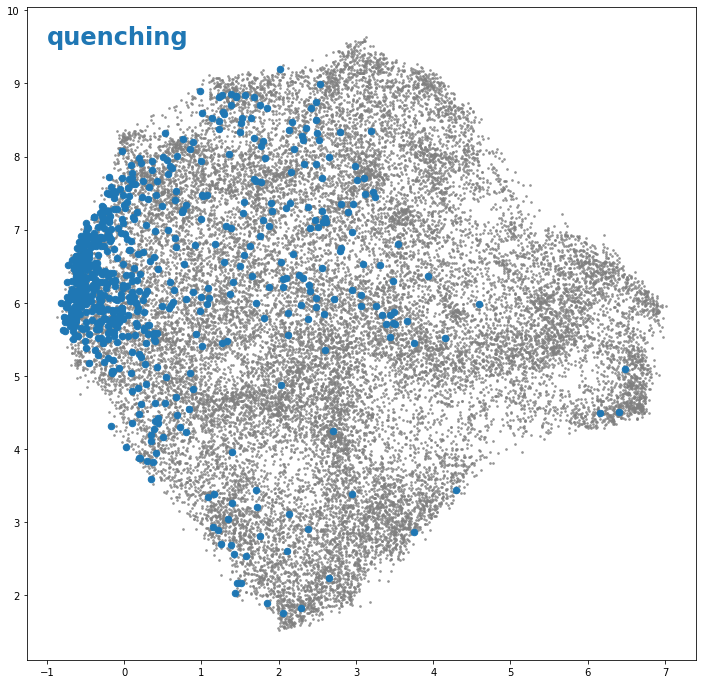

In [14]:
plot_for_phrase(['quenching'])

100%|██████████| 26172/26172 [00:00<00:00, 1478388.79it/s]


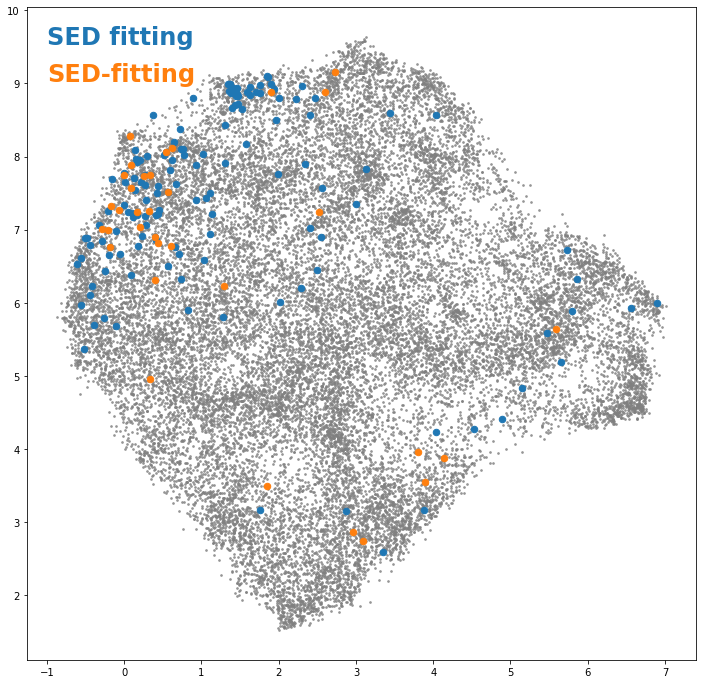

In [15]:
plot_for_phrase(['SED fitting','SED-fitting'])

100%|██████████| 26172/26172 [00:00<00:00, 1243848.08it/s]


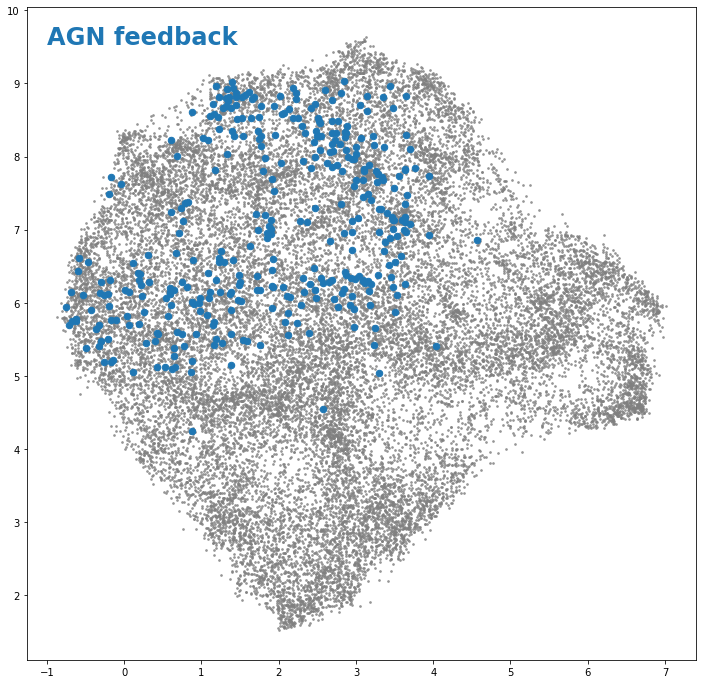

In [16]:
plot_for_phrase(['AGN feedback'])

### Finally, let's check to see if the same phenomenon (in this case, a tight observed correlation between the stellar masses and star formation rates of galaxies) called by different names are found in the same part of the UMAP embedding:

100%|██████████| 26172/26172 [00:00<00:00, 1864166.77it/s]


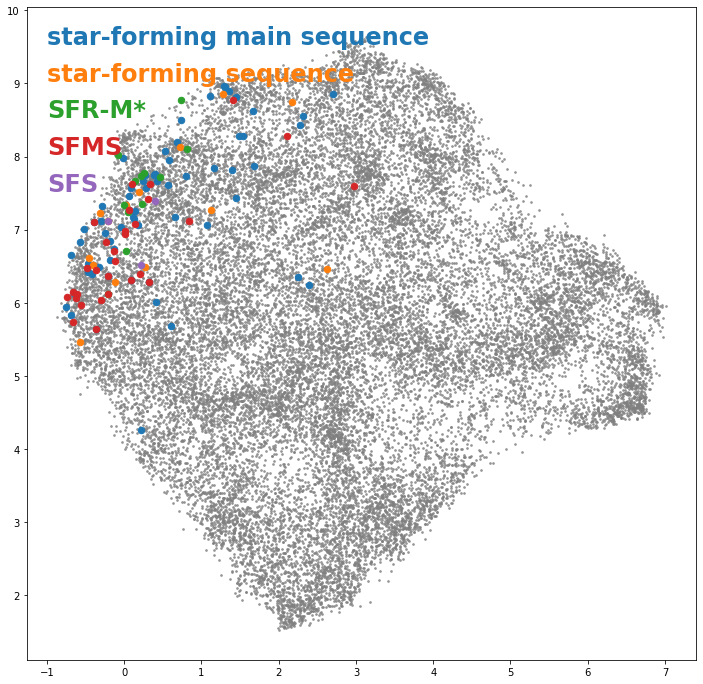

In [17]:
plot_for_phrase(['star-forming main sequence','star-forming sequence','SFR-M*','SFMS','SFS'])

### Checking different simulations

100%|██████████| 26172/26172 [00:00<00:00, 2136374.37it/s]


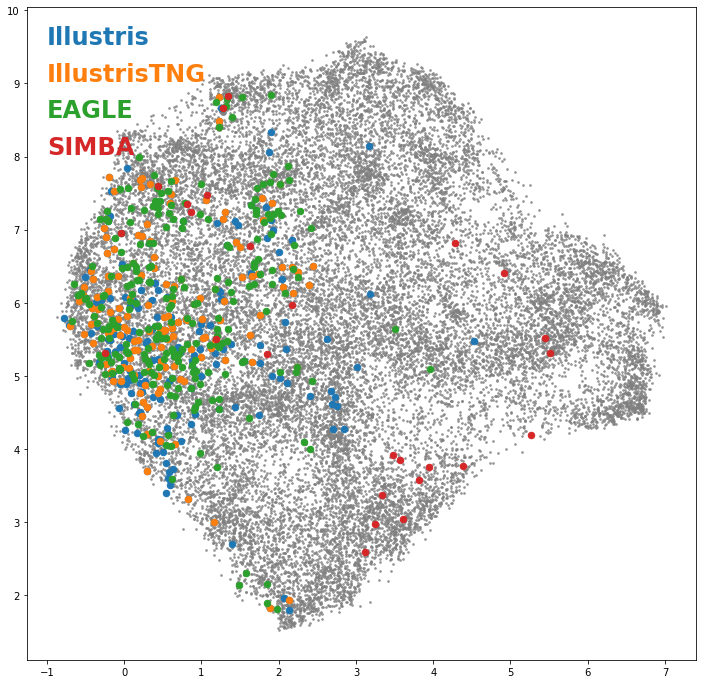

In [18]:
plot_for_phrase(['Illustris','IllustrisTNG','EAGLE','SIMBA'])

### And different telescopes

100%|██████████| 26172/26172 [00:00<00:00, 2144722.35it/s]


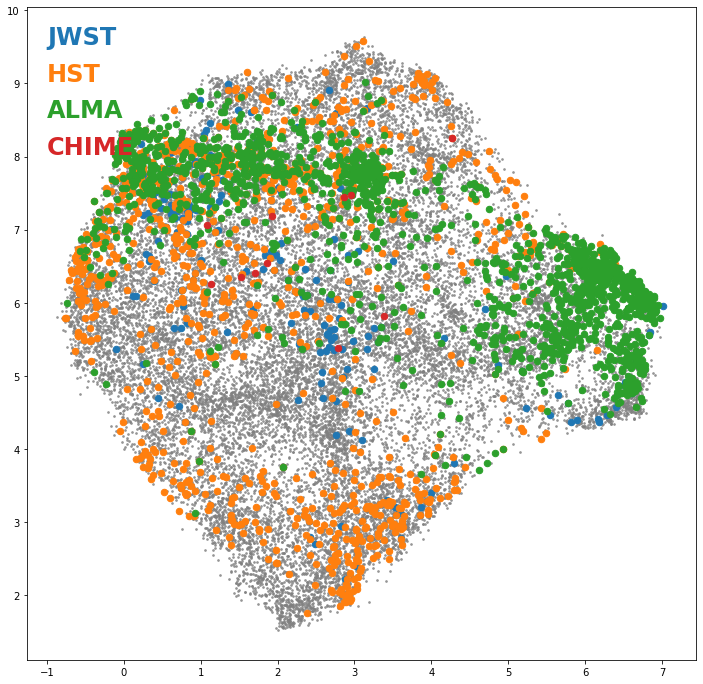

In [19]:
plot_for_phrase(['JWST','HST','ALMA','CHIME'])